In [1]:
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
import xarray
import numpy as np
from pyeosim.datasets import DATA_PATHS
from pyeosim.postprocess import CmosReflectance, CmosReflectance_ff
from pyeosim.sensor import TeledyneCMOS
from pyeosim.atmosphere import Test6S
from pyeosim.plot import rgb
from pyeosim.measure import NDVI
from sklearn import linear_model

In [2]:
# load and preprocess imagery
fpath = DATA_PATHS['TEST_HSI_LARGE']
im = xarray.open_dataset(fpath).Reflectance
im = im.swap_dims({'band':'wavelength'})
im_ref = im.sel(wavelength=slice(400,898)).astype(float)/10000
im_ref = im_ref[:,:,:]

In [3]:
atmos = Test6S()
# generate Top of Atmosphere images
TOA = atmos.transform(im_ref).compute()
TOA_ref = atmos.transform(xarray.ones_like(im_ref))
TOA_10 = atmos.transform(xarray.ones_like(im_ref)*.1)

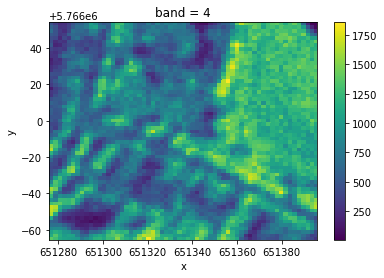

In [4]:
cmos = TeledyneCMOS(integration_time=.001,
                    sense_node_gain=5,
                    dark_current=5,
                    ccd_vref=3.1,
                    adc_gain=2000000,
                    adc_vref=3.1,
                    dark_factor=.1,
                    offset_factor=.001,
                    full_well=1e5,
                    store_steps=True)
cmos.fit(TOA)
cmos.transform(TOA).isel(band=4).plot()

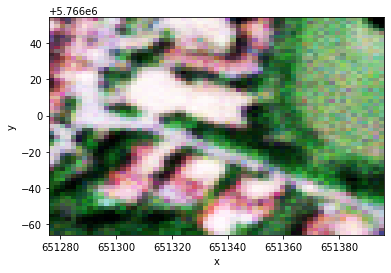

In [5]:
cmos_pipe = CmosReflectance(cmos, TOA_ref)
cmos_pipe.fit(TOA)
ref = cmos_pipe.transform(TOA)
bgr = ref.isel(band=[2,1,0])
rgb(bgr)

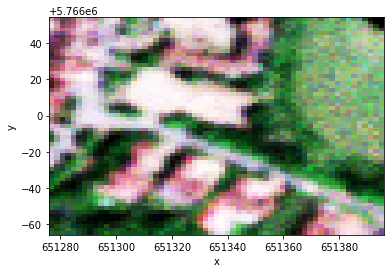

In [6]:
# This version is much slower due to calculation of flat-fielding frames
cmos_pipe = CmosReflectance_ff(cmos, TOA_ref)
cmos_pipe.fit(TOA)
ref = cmos_pipe.transform(TOA)
bgr = ref.isel(band=[2,1,0])
rgb(bgr)

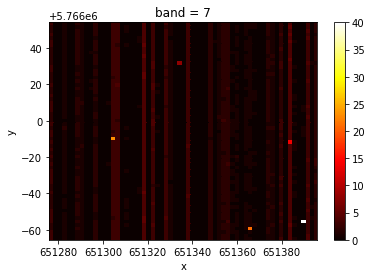

In [7]:
# Generate a sensor dark signal
cmos.transform(xarray.zeros_like(TOA)).isel(band=7).plot(cmap='hot')